In [1]:
# Data Processing
import numpy as np
from numpy import genfromtxt
import sklearn
from sklearn.preprocessing import StandardScaler

# Base classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

# Stacking multiclassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression

# Plotting
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.pyplot as plot
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

## Settings

In [2]:
classical_features_path = 'C:\\Users\\alext\\Desktop\\School\\2021 Spring\\CS 271\\Final Project\\Feature Extraction\\Classical\\Classical Features.csv'
jazz_features_path = 'C:\\Users\\alext\\Desktop\\School\\2021 Spring\\CS 271\\Final Project\\Feature Extraction\\Jazz\\Jazz Features.csv'
roc_export_path = r'C:\Users\alext\Desktop\School\2021 Spring\CS 271\Final Project\Classification\Stack Ensemble ROC Data.csv'

# Set the plot font
font = {'family' : 'DejaVu Sans',
        'size'   : 18}

matplotlib.rc('font', **font)

## Load the Feature Data

In [3]:
def load_samples(group1_path, group2_path, num_train, num_clasif):
    num_to_load = num_train + num_clasif
    
    # Load enough features for training and classification
    group1_features = genfromtxt(group1_path, delimiter=',', max_rows=num_to_load)
    group2_features = genfromtxt(group2_path, delimiter=',', max_rows=num_to_load)
    
    # Get the training features from both groups
    training_X = group1_features[0:num_train, :]
    training_Y = group2_features[0:num_train, :]
    training_samples = np.concatenate((training_X, training_Y), axis=0)
    
    # Get the testing features from both groups
    testing_X = group1_features[num_train:num_to_load, :]
    testing_Y = group2_features[num_train:num_to_load, :]
    testing_samples = np.concatenate((testing_X, testing_Y), axis=0)
    
    # Get the classifications for the training and testing feature sets
    training_classifs = ([0] * num_train) + ([1] * num_train)
    testing_classifs = ([0] * num_clasif) + ([1] * num_clasif)
    
    return (training_samples, training_classifs, testing_samples, testing_classifs)

## Normalize Feature Sets

In [4]:
def normalize_features(training_samples, testing_samples):
    # Compute the mean and varience of each feature in the training set
    scaler = StandardScaler().fit(training_samples)

    # Normalize both the training and testing feature sets
    training_samples = scaler.transform(training_samples)
    testing_samples = scaler.transform(testing_samples)
    
    return (training_samples, testing_samples)

## Plot Accuracies

In [5]:
def plot_accuracies(variables, accuracies, variable_name, title_name):
    # Set the plot size
    figure(figsize=(8, 6), dpi=80)
    
    # Plot the data
    plot.plot(variables, accuracies, marker='.', markersize=15)
    
    # Set the titles
    plot.title(title_name)
    plot.xlabel(variable_name)
    plot.ylabel('Accuracy')
    
    # Force the x-axis to display integer ticks
    ax = plot.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plot.show()

## Compute Average Score

In [6]:
def average_score(score_list):
    total = 0
    
    for score in score_list:
        total += max(score[0], score[1])
    
    return total / len(testing_samples)

## Train Model

In [7]:
def train_model(training_samples, estimators, final_estimator):
    # Train the model using our training data
    model = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
    model.fit(training_samples, training_classifs)
    
    return model

## Load the Full Feature Set

In [8]:
# Load the feature data
# 6000 samples from each genre will be used for training, and 2400 from each for testing
sample_data = load_samples(classical_features_path, jazz_features_path, 6000, 2400)
training_samples  = sample_data[0]
training_classifs = sample_data[1]
testing_samples   = sample_data[2]
testing_classifs  = sample_data[3]

# Normalize the feature sets
(training_samples, testing_samples) = normalize_features(training_samples, testing_samples)

## Creating Estimators

In [9]:
lda_model = LinearDiscriminantAnalysis(solver='svd')
knn_model = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=13, p=1.0)
svm_model = svm.SVC(probability=False, kernel='rbf', C=1, degree=1, gamma=0.08, coef0=1.0)
rf_model  = RandomForestClassifier()

base_learners = [('est_1', lda_model), ('est_2', knn_model), ('est_3', svm_model), ('est_4', rf_model)]

final_estimator = LogisticRegression()

# Training and Testing

In [10]:
# Train the model
print('Training... ', end = '')
model = train_model(training_samples, base_learners, final_estimator)
print('done')

# Calculate the accuracy
print('\nTesting Accuracy... ', end = '')
accuracy = model.score(testing_samples, testing_classifs)
print('done')
print('Accuracy: {}'.format(accuracy * 100))

# Calculate the average score
print('\nTesting Average Score...',  end = '')
score_list = model.predict_proba(testing_samples)
avg_score = average_score(score_list)
print('done')
print('Average Score: {}'.format(avg_score * 100))

Training... done

Testing Accuracy... done
Accuracy: 79.91666666666667

Testing Average Score...done
Average Score: 80.43277325547923


In [16]:
print(testing_samples)

[[-0.55080159  0.17510396 -0.25776487 ... -0.61732953 -0.10413143
  -0.09464812]
 [ 0.36954512  0.51302783 -0.06221737 ... -0.4061839   0.6830587
  -0.34879877]
 [ 0.63494216 -0.42401314 -0.32122655 ... -0.64284704 -0.75286541
   0.21052561]
 ...
 [ 0.21643624 -1.17893375 -0.90930477 ...  1.70922326 -1.31562261
   1.06031485]
 [-0.08645053  2.53991196 -0.33656773 ... -0.52201541  1.61773065
  -0.54796959]
 [-0.05486672  1.39262814 -0.6266234  ... -0.68457568  1.37559314
  -0.89277172]]


## Plotting the ROC Curve

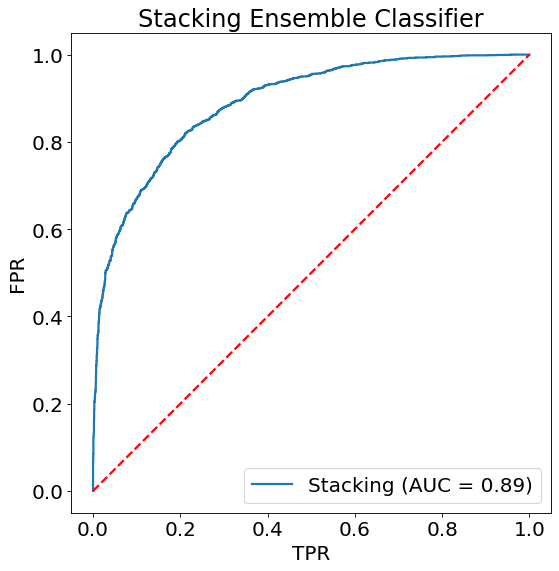

In [11]:
fpr, tpr, threshold = roc_curve(testing_classifs, score_list[:, 1])
roc_auc = auc(fpr, tpr)

# Set the plot settings
fig = figure(figsize=(6, 6), dpi=80)
ax = fig.add_axes([0,0,1,1])
plot.title('Stacking Ensemble Classifier')
plot.xlabel('TPR')
plot.ylabel('FPR')

# Plot the ROC
plot.plot(fpr, tpr, lw=2, label='Stacking (AUC = %0.2f)' % roc_auc)

# Draw the middle line
plot.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

plot.legend(loc='lower right')
plot.show()

## Export FPR and TPR

In [12]:
print('Exporting ROC Data...')

f = open(roc_export_path, "w")

for item in range(fpr.shape[0]):
    f.write(str(fpr[item]) + ',' + str(tpr[item]) + '\n')

f.close()

print('Finished')

Exporting ROC Data...
Finished
